# Проект 1. "Угадай знаменитость"

## Классификация изображений, распознавание лиц

##### Представлены обучающий и валидационный датасеты с фотографиями пяти известных людей. Необходимо разработать классификатор на базе предобученной сверточной нейросети для распознавания по фото.

Загружаем необходимые библиотеки, определяем наличие видеокарты, задаем путь к данным и размер батча для обучения.

In [1]:
import os.path
import random
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
from torchvision import models
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PATH = 'C://Users//data//'
BATCH_SIZE = 32

Поскольку датасет имеет подходящий вид (фото сгруппированы в подкаталогах с названиями классов), используем готовый конструктор датасета ImageFolder.

In [2]:
!tree -c {PATH}

‘«ЁиЄ®¬ ¬­®Ј® Ї а ¬Ґва®ў: C://Users//data//


In [3]:
train_dset = torchvision.datasets.ImageFolder(os.path.join(PATH, 'train/'))
valid_dset = torchvision.datasets.ImageFolder(os.path.join(PATH, 'valid/'))

Можно просмотреть случайно выбранные фотографии.

In [4]:
def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(2 * num_samples, 1.5))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title(random_label.replace("_", " ").title())
        axes[i].axis('off')

    plt.show()

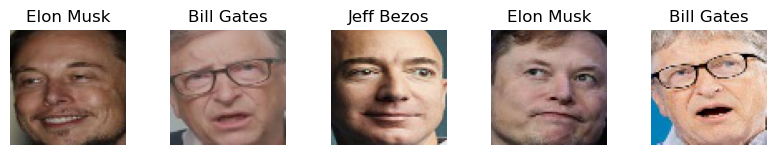

In [5]:
plot_samples(train_dset)

Выполняем предобработку обучающего и валидационного датасетов. Датасеты содержат изображения лиц низкого разрешения, как правило 70x70
 пикселей, пропорции не соблюдаются. Переводим все изображения в стандартный формат 70x70
, затем в PyTorch-тензор с нормализацией датасета ImageNet (будет использоваться модель, обученная на этом датасете). Для обучающего датасета добавляем аугментации: "зеркало", изменение резкости, контраста и выравнивание гистограммы.

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dset.transform = transforms.Compose([
    transforms.Resize([70, 70]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAdjustSharpness(random.uniform(0, 2)),
    transforms.RandomAutocontrast(),
    transforms.RandomEqualize(),
    transforms.ToTensor(), 
    normalize
])

valid_dset.transform = transforms.Compose([
    transforms.Resize([70, 70]),
    transforms.ToTensor(),
    normalize
])

Создаем загрузчики данных

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=os.cpu_count()
)
valid_loader = torch.utils.data.DataLoader(
    valid_dset, batch_size=BATCH_SIZE, 
    shuffle=False, num_workers=os.cpu_count()
)

Будем использовать предобученную модель EfficientNetV2-s 2021 года (arxiv:2104.00298). Выбор модели обусловлен относительно высокой точностью (acc ~ 84%, acc@5 ~ 97% на датасете ImageNet) при относительно небольшом количестве параметров, ~20 млн. Также стоит отметить, что модель доступна в библиотеке PyTorch. Входной формат модели, 384x384 пикселей, больше размера наших фото, однако в модели есть адаптивный слой AdaptiveAvgPool2d, а веса согласно документации пригодны до минимального размера 33x33.

Меняем последний слой классификатора для соответствия количеству классов, замораживаем веса модели вплоть до 6-го блока экстрактора признаков (features): будем дообучать 6-й и 7-й блоки экстрактора и блок классификатора. 

Используем кросс-энтропию в качестве функции потерь и оптимизатор Adam с шагом обучения 0.0001. Модель и функцию потерь передаем на GPU (при наличии).

In [8]:
model = models.efficientnet_v2_s(
    weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model.classifier[1] = torch.nn.Linear(1280, len(train_dset.classes))

for params in model.parameters():
    params.requires_grad = True
for index, block in enumerate(model.features):
    if index < 6:
        for params in block.parameters():
            params.requires_grad = False
        
all_params = sum(p.numel() for p in model.parameters())
train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'No of parameters: {all_params}')
print(f'No of trainable parameters: {train_params}')  
    
criterion = torch.nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

No of parameters: 20183893
No of trainable parameters: 14898477


Функция для обучения модели train_model и функция process_epoch, которая вызывается из train_model и обрабатывает одну эпоху обучения для обучающей и валидационной выборок.

In [23]:
def process_epoch(model, optimizer, loader, mode='eval'):
    if mode == 'train':
        # расчёты градиента
        torch.set_grad_enabled(True)
        # модель в тренировочном режиме
        model.train()
    else:
        torch.set_grad_enabled(False)
        model.eval()
        
    losses = []   # Значения функции потерь для каждого пакета
    matches = []  # True/False классы для каждого образца
    
    for images, targets in loader:
        # файлы GPU/CPU
        images = images.to(device)
        targets = targets.to(device)

        # функция прямого распространения и потерь
        output = model(images)
        loss = criterion(output, targets)

        # сохранение метрик для пакета
        losses.append(loss.item())
        matches.extend(
            [x.item() for x in torch.argmax(output, 1) == targets])

        # обратное распространение и этап обучения
        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Функция возврата потерь и точность для определенной эпохи 
    return np.mean(losses), np.mean(matches)
  

def train_model(model, optimizer, train_loader, valid_loader, num_epochs=10):
    # Списки для сохранения значений функции потерь и точности за определенную эпоху
    loss_train, acc_train,  loss_valid, acc_valid = [], [], [], []
    
    best_acc = 0
    for epoch in tqdm(range(num_epochs)):
        loss, acc = process_epoch(model, optimizer, train_loader, mode='train')
        loss_train.append(loss)
        acc_train.append(acc)
        
        loss, acc = process_epoch(model, optimizer, valid_loader, mode='eval')
        loss_valid.append(loss)
        acc_valid.append(acc)
           
    return loss_train, acc_train, loss_valid, acc_valid

Обучаем модель в течение 20 эпох.

In [24]:
loss_train, acc_train, loss_valid, acc_valid = train_model(
    model, optimizer, train_loader, valid_loader, num_epochs=20)

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [2:50:44<00:00, 512.24s/it]


Best accuracy for the validation: 0.9869


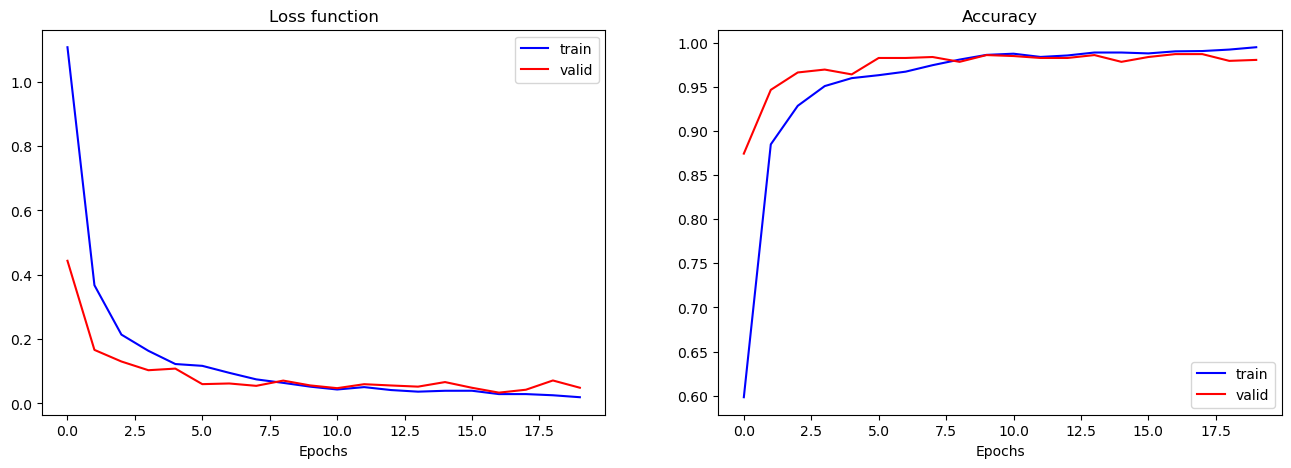

In [11]:
print(f'Best accuracy for the validation: {max(acc_valid):.4f}')

plt.figure(figsize=(16, 5))
x_max = len(loss_train)

plt.subplot(121)
plt.plot(range(x_max), loss_train, color='b', label='train')
plt.plot(range(x_max), loss_valid, color='r', label='valid')
plt.legend()
plt.title('Loss function')
plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(range(x_max), acc_train, color='b', label='train')
plt.plot(range(x_max), acc_valid, color='r', label='valid')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')

plt.show()

Кривые функции потерь(loss function) и точности acc(accuracy) для обучающей и валидационной выборок. Видно, что примерно после 10-й эпохи начинается тенденция к переобучению: результаты на обучающей выборке периодически лучше валидационной. На валидационной выборке достигнута точность более 98%.

Вывод

На основе предобученной модели EfficientNetV2-s разработан классификатор изображений для распознавания лиц пяти известных людей. Достигнута точность на валидации более 98%. Для корректной работы модели необходимо, чтобы на фото по возможности было только лицо. Небольшой размер изображений обучающего датасета и малый размер модели позволили провести обучение (20 эпох), но в связи довольно старой и слабой видеокартой процесс длился примерно 2.5 часа на слабом GPU: GeForce 550 Ti с 1 Гб памяти и 192 CUDA-ядрами.